In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image, ImageDraw, ImageFont, ImageOps, ImageColor
import os
import detect
import platform
import datetime
import cv2
import time
import numpy as np
import io
from io import BytesIO
from flask import Flask, request, Response, jsonify
import random
import re
import base64
import matplotlib.pyplot as plt

### 1. Define functions for plotting and drawing boxes
taken from here: https://www.tensorflow.org/hub/tutorials/object_detection

In [29]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
                (left, top)],
                width=thickness,
                fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin

def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                         int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
              image_pil,
              ymin,
              xmin,
              ymax,
              xmax,
              color,
              font,
              display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

def display_image(image): # image must be in numpy format for this function
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)

def add_detections(result,max_length,det):
    det["entities"].append(result["detection_class_entities"][:max_length])
    det["scores"].append(result["detection_scores"][:max_length])
    det["boxes"].append(result["detection_boxes"][:max_length])
    return det

### 2. Load the pre-trained model

In [2]:

model_path = r"https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
detector = hub.load(model_path).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


### 3. Load all images (from a local repo) into a list

In [37]:
folder_path = "images" # images folder in the local repo
images_1 = []

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    # Construct the full file path
    file_path = os.path.join(folder_path, filename)

    # Check if the file is a JPEG image
    if os.path.isfile(file_path) and filename.lower().endswith(".jpg"):
        with open(file_path, "rb") as file:
            # Read the image data
            image_data = file.read()
            image_data = BytesIO(image_data)
            
            pil_image = Image.open(image_data)
            # pil_image = ImageOps.fit(pil_image, (300, 300), Image.ANTIALIAS)
            pil_image_rgb = pil_image.convert("RGB")
            images_1.append(pil_image_rgb)

len(images_1)

296

### 4. Pick one of 296 images

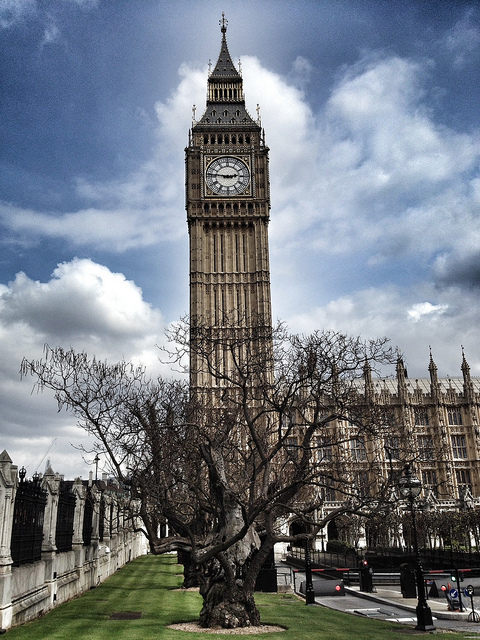

In [46]:
image_nr = 5
test_img = images_1[image_nr]
test_img

### 5. Change the image format

In [47]:
# convert to numpy array
image_np = np.array(test_img) 

# normalize the values so they are between 0 and 1
normalized_array = (image_np - image_np.min()) / (image_np.max() - image_np.min()) 

# convert to tensor and adjust shape
image_tensor_1 = tf.convert_to_tensor(normalized_array, dtype=tf.float32)
image_tensor = tf.image.convert_image_dtype(image_tensor_1, dtype=tf.float32)[tf.newaxis, ...]

### 6. Perform detection and show results

In [48]:
start_time = time.time()
result = detector(image_tensor)
end_time = time.time()
result = {key:value.numpy() for key,value in result.items()}

print("Found %d objects." % len(result["detection_scores"]))
print("Inference time: ", end_time-start_time)

Found 100 objects.
Inference time:  0.1152200698852539


In [49]:
det = {"entities" : [], "scores" : [], "boxes" : []}
add_detections(result,10,det)

{'entities': [array([b'Tower', b'Tree', b'Tower', b'Tree', b'Tree', b'Tree', b'Tree',
         b'Tree', b'Tree', b'Tree'], dtype=object)],
 'scores': [array([0.51110923, 0.37103128, 0.3084639 , 0.2412026 , 0.2041363 ,
         0.18837361, 0.18686885, 0.18472412, 0.17992759, 0.17477506],
        dtype=float32)],
 'boxes': [array([[0.04003462, 0.37533897, 0.6965368 , 0.58808625],
         [0.46643528, 0.05384085, 0.9641429 , 0.8766353 ],
         [0.02044952, 0.28818125, 0.8527457 , 0.62419933],
         [0.5345751 , 0.05238554, 0.8996922 , 0.5533631 ],
         [0.5027008 , 0.33473158, 0.9502884 , 0.86868906],
         [0.3624835 , 0.28066906, 0.95944035, 0.69261587],
         [0.49887407, 0.02717251, 0.8415196 , 0.3858286 ],
         [0.54042614, 0.06268729, 0.7811161 , 0.29312384],
         [0.6068221 , 0.25952446, 0.85492843, 0.42526448],
         [0.5629678 , 0.25935093, 0.92714703, 0.6516317 ]], dtype=float32)]}

### 7. Show results on plotted image with boxes of top 10 objects

Font not found, using default font.


C:\Users\leond\AppData\Local\Temp\ipykernel_13800\279267069.py:23: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
C:\Users\leond\AppData\Local\Temp\ipykernel_13800\279267069.py:33: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


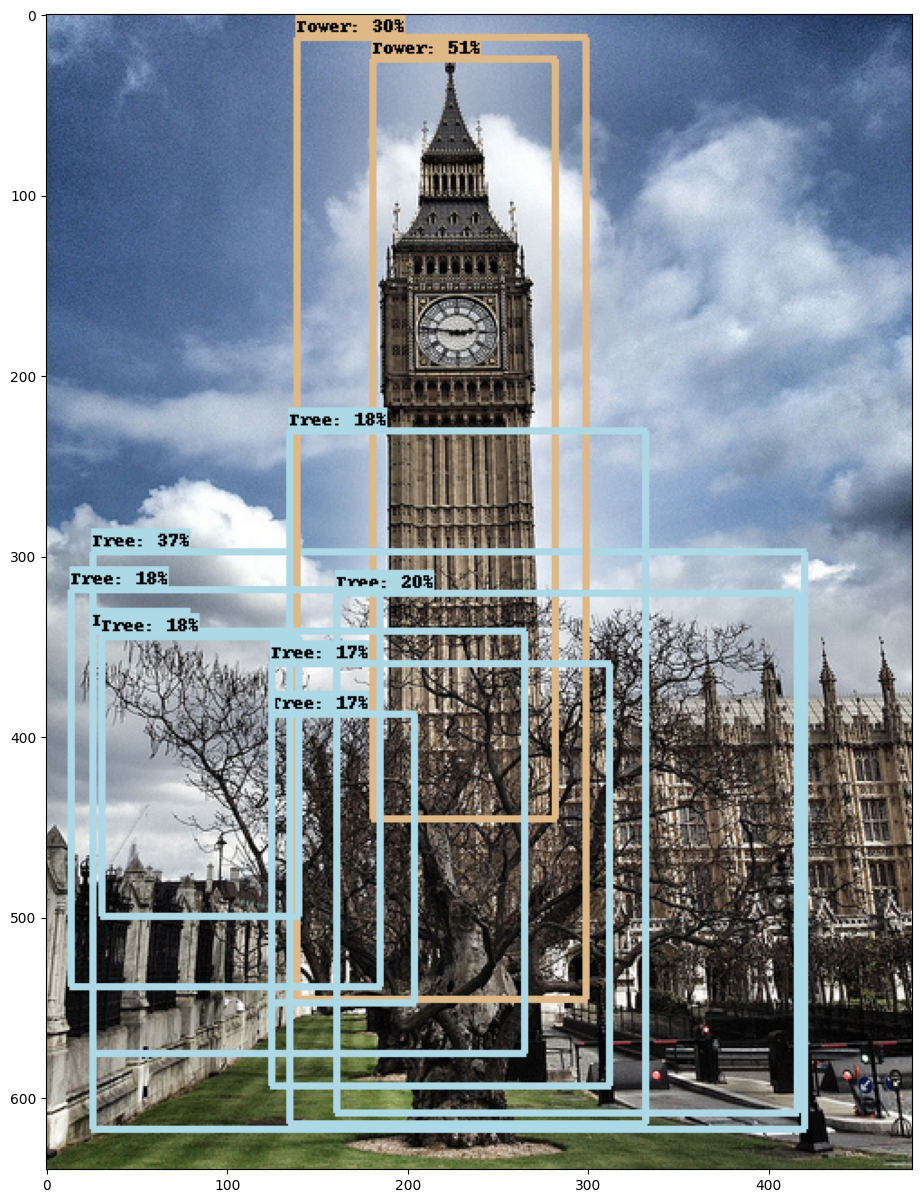

In [50]:
image_with_boxes = draw_boxes(
    image_np, result["detection_boxes"],
    result["detection_class_entities"], result["detection_scores"])

display_image(image_with_boxes)